In [1]:
from pathlib import Path

base_path = Path.cwd()

# Lendo os dados

Lembre-se de ter rodado o notebook anterior antes de ler os dados aqui!

In [50]:
from projeto.dataset import load_processed_datasets

X, y, X_train, X_test, y_train, y_test = load_processed_datasets(base_path)

y_train = (y_train == '>50K').astype(int)
y_test = (y_test == '>50K').astype(int)

# Escolha de modelo

Teste os seguintes modelos:

- Dummy classifier

- Logistic regression com regularização L2 (`sklearn.linear_model.LogisticRegression(penalty='l2', C=1.0)`) para valores de C entre $10^{-3}$ e $10^{3}$

- Logistic regression com regularização L2 como no caso anterior e features polinomiais. Experimente com grau polinomial entre $2$ e $3$

- Classificador do tipo Support Vector Machines com kernel polinomial (`sklearn.svm.SVC(C=1.0, degree=2)`), teste valores de C entre $10^{-3}$ e $10^{3}$ e graus entre $1$ e $5$.

    - Atenção: este modelo demora MUITO para treinar, portanto vamos treiná-lo com um subconjunto PEQUENO de amostras. Você pode usar o seguinte código para construir um *dataset* de treino pequeno:

        ```Python
        subset_indexes = np.random.choice(X_train.index, size=5000, replace=False, random_state=42)
        X_train_subset = X_train.loc[subset_indexes]
        y_train_subset = y_train.loc[subset_indexes]
        ```

    Somente o `SVC` será treinado com um *dataset* pequeno.

- Classificador do tipo Random Forest (`sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, max_features=1.0, n_jobs=-1)`), varie o parâmetro `n_estimators` com os valores $\{2, 8, 32, 128, 512\}$, o parâmetro `max_depth` variando em $\{1, 4, 16, 64, \text{None}\}$ e o parâmetro `max_features` variando em $\{0.1, 0.3, 0.5, 0.7, 1.0\}$

- Classificador do tipo `sklearn.ensemble.HistGradientBoostingClassifier(max_depth=None, max_features=1.0)` com o parâmetro `max_depth` variando em $\{1, 4, 16, 64, \text{None}\}$ e o parâmetro `max_features` variando em $\{0.1, 0.3, 0.5, 0.7, 1.0\}$

Construa pipelines adequadas, e use o `sklearn.model_selection.GridSearchCV` para escolher o melhor modelo de cada categoria, e então determine qual o melhor modelo de todos.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import warnings

num_features = ['age', 'education.num', "hours.per.week"]
cat_features = ['workclass', "education", "marital.status", "occupation", "relationship", 'race', 'sex']


### Pipeline transform

In [4]:
pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pipe_cat = Pipeline([
    ("imput", SimpleImputer(strategy="most_frequent")),
    ("hotEncoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    [
        ('num', pipe_num, num_features),
        ('cat', pipe_cat, cat_features),
    ],
    remainder='passthrough',
)


### Dummy

In [ ]:

dummy = Pipeline([
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy="most_frequent"))
])

dummy.fit(X_train, y_train) # Tempo de treino = 0.0s
dummy_pred = dummy.predict(X_test)

### Logistic

In [ ]:
params1 = {
    'log_reg1__C': np.logspace(-3, 3, 7)
}

log_reg1 = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg1", LogisticRegression(penalty='l2', max_iter=3700, solver='lbfgs', random_state=42))
])

log1_grid_search = GridSearchCV(
    estimator = log_reg1,
    param_grid = params1,
    cv = 4,
    n_jobs = -1,
    scoring = 'f1',
    verbose = 3
    # return_train_score=True
)

log1_grid_search.fit(X_train, y_train) # Tempo de treino = 1.40 min
log1_pred = log1_grid_search.best_estimator_.predict(X_test)


Fitting 4 folds for each of 7 candidates, totalling 28 fits


c:\Users\Danie\anaconda3\envs\alglin\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3700 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3700).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

warnings.filterwarnings('ignore')

params2 = {
    'log_reg2__C': np.logspace(-3, 3, 7),
    'poly__degree': [2, 3]
}

log_reg2 = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("log_reg2", LogisticRegression(penalty='l2', max_iter=700, solver='lbfgs',  random_state=42))
])

log2_grid_search = GridSearchCV(
    estimator = log_reg2,
    param_grid = params2,
    cv = 2,
    n_jobs = 1,
    scoring = 'f1',
    verbose = 3
    # return_train_score=True
)

log2_grid_search.fit(X_train, y_train) # Tempo de treino = 93.29 min
log2_pred = log2_grid_search.best_estimator_.predict(X_test)

Fitting 2 folds for each of 14 candidates, totalling 28 fits
[CV 1/2] END .log_reg2__C=0.001, poly__degree=2;, score=0.425 total time=  16.1s
[CV 2/2] END .log_reg2__C=0.001, poly__degree=2;, score=0.417 total time=  17.4s
[CV 1/2] END .log_reg2__C=0.001, poly__degree=3;, score=0.459 total time= 4.7min
[CV 2/2] END .log_reg2__C=0.001, poly__degree=3;, score=0.471 total time= 5.3min
[CV 1/2] END ..log_reg2__C=0.01, poly__degree=2;, score=0.426 total time=  16.0s
[CV 2/2] END ..log_reg2__C=0.01, poly__degree=2;, score=0.415 total time=  16.7s
[CV 1/2] END ..log_reg2__C=0.01, poly__degree=3;, score=0.465 total time= 5.3min
[CV 2/2] END ..log_reg2__C=0.01, poly__degree=3;, score=0.472 total time= 5.2min
[CV 1/2] END ...log_reg2__C=0.1, poly__degree=2;, score=0.428 total time=  16.8s
[CV 2/2] END ...log_reg2__C=0.1, poly__degree=2;, score=0.417 total time=  16.7s
[CV 1/2] END ...log_reg2__C=0.1, poly__degree=3;, score=0.468 total time= 5.0min
[CV 2/2] END ...log_reg2__C=0.1, poly__degree=3;

### Suport Vector Machine

In [8]:
np.random.seed(42)
subset_indexes = np.random.choice(X_train.index, size=3000, replace=False)
X_train_subset = X_train.loc[subset_indexes]
y_train_subset = y_train.loc[subset_indexes]

In [ ]:
params = {
    'sup_ver_mach__C': np.logspace(-3, 3, 7),
    'sup_ver_mach__kernel': ['poly'],
    'sup_ver_mach__degree' : [2, 3, 4]
}

sup_ver_mach = Pipeline([
    ("preprocessor", preprocessor),
    ("sup_ver_mach", SVC(random_state=42, class_weight='balanced'))
])

svm_grid_search = GridSearchCV(
    estimator = sup_ver_mach,
    param_grid = params,
    cv = 2,
    scoring = 'f1',
    n_jobs = 1,
    verbose = 3
)

svm_grid_search.fit(X_train_subset, y_train_subset) # Tempo de treino =  5.14 min
svm_pred = svm_grid_search.best_estimator_.predict(X_test)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
[CV 1/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=2, sup_ver_mach__kernel=poly;, score=0.190 total time=   0.0s
[CV 2/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=2, sup_ver_mach__kernel=poly;, score=0.121 total time=   0.0s
[CV 1/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=3, sup_ver_mach__kernel=poly;, score=0.190 total time=   0.0s
[CV 2/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=3, sup_ver_mach__kernel=poly;, score=0.146 total time=   0.0s
[CV 1/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=4, sup_ver_mach__kernel=poly;, score=0.190 total time=   0.0s
[CV 2/2] END sup_ver_mach__C=0.001, sup_ver_mach__degree=4, sup_ver_mach__kernel=poly;, score=0.146 total time=   0.0s
[CV 1/2] END sup_ver_mach__C=0.01, sup_ver_mach__degree=2, sup_ver_mach__kernel=poly;, score=0.323 total time=   0.0s
[CV 2/2] END sup_ver_mach__C=0.01, sup_ver_mach__degree=2, sup_ver_mach__kernel=poly;, score=0.151 total ti

### Random Forest

In [ ]:

params = {
    'rand_forest__n_estimators': [2, 8, 32, 128, 512],
    'rand_forest__max_depth': [1, 4, 16, 64, None],
    'rand_forest__max_features': [0.1, 0.3, 0.5, 0.7, 1.0]
}

rand_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("rand_forest", RandomForestClassifier(n_jobs=-1))
])

rand_grid_search = GridSearchCV(
    estimator=rand_forest,
    param_grid=params,
    cv=3,
    scoring='f1',
    n_jobs = 1,
    verbose = 3,
    return_train_score=True
)

rand_grid_search.fit(X_train, y_train) # Tempo de treino = 7.15 min
rand_pred = rand_grid_search.best_estimator_.predict(X_test)


Fitting 3 folds for each of 125 candidates, totalling 375 fits
[CV 1/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=2;, score=(train=0.000, test=0.000) total time=   0.2s
[CV 2/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=2;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=2;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=8;, score=(train=0.000, test=0.000) total time=   0.1s
[CV 2/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/3] END rand_forest__max_depth=1, rand_forest__max_features=0.1, rand_forest__n_estimators=8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/3] END rand_forest__max_d

### Hist Gradient

In [ ]:

params = {
    'hist_grad__max_depth': [1, 4, 16, 64],
    'hist_grad__max_features': [0.1, 0.3, 0.5, 0.7, 1.0]
}

hist_grad = Pipeline([
    ("preprocessor", preprocessor),
    ("hist_grad", HistGradientBoostingClassifier())
])

hist_grid_search = GridSearchCV(
    estimator=hist_grad,
    param_grid=params,
    cv=5,
    scoring='f1',
    n_jobs = 1,
    verbose = 3,
    return_train_score=True
)

hist_grid_search.fit(X_train, y_train) # Tempo de treino = 1.29 min
hist_pred = hist_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END hist_grad__max_depth=1, hist_grad__max_features=0.1;, score=(train=0.610, test=0.608) total time=   0.4s
[CV 2/5] END hist_grad__max_depth=1, hist_grad__max_features=0.1;, score=(train=0.595, test=0.597) total time=   0.2s
[CV 3/5] END hist_grad__max_depth=1, hist_grad__max_features=0.1;, score=(train=0.612, test=0.620) total time=   0.4s
[CV 4/5] END hist_grad__max_depth=1, hist_grad__max_features=0.1;, score=(train=0.618, test=0.593) total time=   0.4s
[CV 5/5] END hist_grad__max_depth=1, hist_grad__max_features=0.1;, score=(train=0.613, test=0.614) total time=   0.2s
[CV 1/5] END hist_grad__max_depth=1, hist_grad__max_features=0.3;, score=(train=0.630, test=0.626) total time=   0.3s
[CV 2/5] END hist_grad__max_depth=1, hist_grad__max_features=0.3;, score=(train=0.629, test=0.626) total time=   0.4s
[CV 3/5] END hist_grad__max_depth=1, hist_grad__max_features=0.3;, score=(train=0.623, test=0.624) total time=  

In [ ]:

modelos = {
    "Dummy": dummy_pred, # t = 0
    'Logistic Regression 1': log1_pred, # t = 1.40 min
    'Logistic Regression 2(Polyniomial Features)': log2_pred, # t = 93.29 min
    'SVM': svm_pred, # t = 5.14 min
    "Random Forest Classifier": rand_pred, # 7.15 min
    'Hist Gradient Boosting Classifier': hist_pred # 1.29 min
}

for name, pred in modelos.items():
    print(f"{name}: {accuracy_score(y_test, pred)*100:.2f}%")

Dummy: 75.61%
Logistic Regression 1: 85.09%
Logistic Regression 2(Polyniomial Features): 78.63%
SVM: 80.07%
Random Forest Classifier: 85.84%
Hist Gradient Boosting Classifier: 87.32%


# Certificação

Para o modelo escolhido:

- Efetue a etapa de certificação.

- Construa a curva ROC deste modelo e calcule a área sobre a curva ROC.

- Discuta os resultados.

### Etapa Certificação
#### Apresentando detalhes do modelo e  confusion matrix

In [ ]:
hist_pred = hist_grid_search.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, hist_pred)
tn, fp, fn, tp = cm.ravel()

total = len(y_test)

total_positive = (y_test == 1).sum()
total_negative = (y_test == 0).sum()

print(f"\n Hist Gradient Boosting Classifier \n")
print(f"Precision: {precision_score(y_test, hist_pred):.3f}")
print(f"Recall: {recall_score(y_test, hist_pred):.3f}")
print(f"Accuracy: {accuracy_score(y_test, hist_pred):.3f}")

print(f"\nTabela: Predição X Real")
print(f"TN: {(tn/total)*100:.2f}% | FP: {(fp/total)*100:.2f}%")
print(f"FN: {(fn/total)*100:.2f}% | TP: {(tp/total)*100:.2f}%\n")


# print(f"Probabilidades: {hist_pred}")


 Hist Gradient Boosting Classifier 

F1-Score: 0.717
Precision: 0.786
Recall: 0.660
Accuracy: 0.873

Tabela: Predição X Real
TN: 71.22% | FP: 4.39%
FN: 8.30% | TP: 16.10%



### Curva ROC/Área

Site usado para geração da curva: [Curva ROC em python](https://www-geeksforgeeks-org.translate.goog/machine-learning/how-to-plot-roc-curve-in-python/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc)

In [65]:
def calcula_area_curvaROC(nome, modelo_pred):
    taxa_FP, taxa_TP, thresholds = roc_curve(y_test, modelo_pred) 
    area_curvaROC = auc(taxa_FP, taxa_TP)

    plt.figure()
    plt.plot(taxa_FP, taxa_TP, label='ROC curve (area = %0.2f)' % area_curvaROC)
    plt.plot([0, 1], [0, 1], 'k--', label='Faixa de desempenho mínimo')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa FP')
    plt.ylabel('Taxa TP')
    plt.title(f'{nome} --> Target: Income(> 50)')
    plt.legend()
    plt.show()

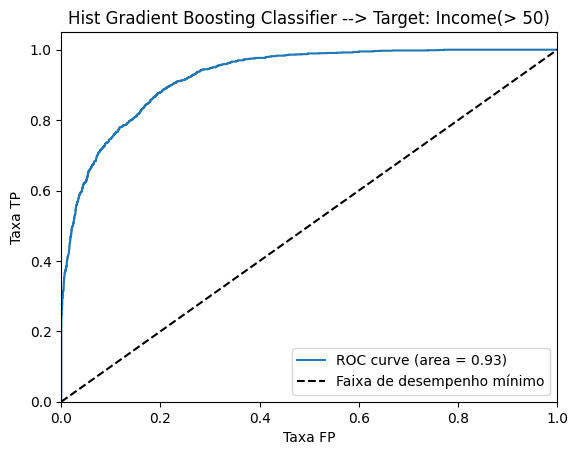

In [68]:
hist_pred_prob = hist_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

calcula_area_curvaROC("Hist Gradient Boosting Classifier", hist_pred_prob)

In [67]:
# modelos = {
#     # "Dummy": dummy_pred, 
#     'Logistic Regression 1': log1_grid_search.best_estimator_.predict_proba(X_test)[:, 1], 
#     'Logistic Regression 2(Polyniomial Features)': log2_grid_search.best_estimator_.predict_proba(X_test)[:, 1], 
#     'SVM': svm_grid_search.best_estimator_.predict_proba(X_test)[:, 1], 
#     "Random Forest Classifier": rand_grid_search.best_estimator_.predict_proba(X_test)[:, 1], 
#     'Hist Gradient Boosting Classifier': hist_grid_search.best_estimator_.predict_proba(X_test)[:, 1]
# }

# for nome, modelo in modelos.items():
#     calcula_area_curvaROC(nome, modelo)

# Deploy

Retreine o modelo no conjunto completo de dados.

Demonstre como você:

- Grava o modelo treinado no disco

- Lê o modelo treinado do disco

- Usa o modelo treinado para fazer uma predição para um novo item.